Comment utiliser le pipeline de sk learn

In [1]:
from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline, make_union
from sklearn.compose import make_column_transformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, OrdinalEncoder, OneHotEncoder, Binarizer, KBinsDiscretizer, QuantileTransformer, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV

import pandas as pd
import numpy as np

dataframe = pd.read_csv("dataset.csv", sep=",", index_col=False)
dataframe.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [2]:
#no age encoder
sex_encoder = OrdinalEncoder(categories=[['female', 'male']])

#bmi_encoder = Binarizer(threshold=30)

#bmi_encoder = KBinsDiscretizer(n_bins = 30, encode='ordinal')
# bmi_encoder.bin_edges_ = bmi_thresholds

from custom_digitizer import CustomDigitizer

bmi_thresholds = np.array([0, 18.5, 25, 30, 35, 40])
bmi_encoder = CustomDigitizer(bins = bmi_thresholds)

#no children encoder
smoker_encoder = OrdinalEncoder(categories=[['no', 'yes']])
region_encoder = OneHotEncoder()

#dataframe[["bmi"]].head()
result = bmi_encoder.fit_transform(dataframe[["bmi"]])
result

array([[3],
       [4],
       [4],
       ...,
       [5],
       [3],
       [3]], shape=(1338, 1))

In [3]:
dataframe = dataframe[ dataframe['charges'] <= 60000]

y = dataframe['charges']
X = dataframe.drop('charges', axis=1)

# pour pouvoir comparer le score
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.85, random_state=42, stratify=X['smoker'])


In [4]:
age_pipeline = make_pipeline( StandardScaler()) #, PolynomialFeatures(degree=2))
sex_pipeline = make_pipeline( sex_encoder)
bmi_pipeline = make_pipeline( bmi_encoder, OneHotEncoder())
children_pipeline = make_pipeline( StandardScaler())
smoker_pipeline = make_pipeline( smoker_encoder)
region_pipeline = make_pipeline( region_encoder)

In [5]:
first_pipeline = make_column_transformer(
    (age_pipeline, ['age']),  
    (bmi_pipeline, ['bmi']),
    (smoker_pipeline, ['smoker']))
    
polynomial_pipeline = make_pipeline(first_pipeline, PolynomialFeatures(degree=2))

preprocessor = make_column_transformer( 
    (polynomial_pipeline, ['age', 'bmi', 'smoker']),
    (sex_pipeline, ['sex']), 
    (children_pipeline, ['children']),
    (region_pipeline, ['region'])) 

In [6]:
model = make_pipeline(preprocessor, LassoCV( cv=5))
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('columntransformer',
                                                                   ColumnTransformer(transformers=[('pipeline-1',
                                                                                                    Pipeline(steps=[('standardscaler',
                                                                                                                     StandardScaler())]),
                                                                                                    ['age']),
                                                                                                   ('pipeline-2',
                                                                                                    Pipeline(steps=[('customdigitizer',
                                                                                                                     CustomDigitizer(bins=array([ 0. , 18.5, 25. , 30. , 35. , 40. ]))),
                                                                                                                    ('onehotencoder'...
                                                                  ('polynomialfeatures',
                                                                   PolynomialFeatures())]),
                                                  ['age', 'bmi', 'smoker']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['female',
                                                                                               'male']]))]),
                                                  ['sex']),
                                                 ('pipeline-3',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['children']),
                                                 ('pipeline-4',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['region'])])),
                ('lassocv', LassoCV(cv=5))])

In [7]:
# import sklearn.model_selection as skl_mod_sel

# grid = skl_mod_sel.GridSearchCV(
#     model, 
#     param_grid = { 'polynomial_features__degree': [2, 3, 4] }, 
#     cv=4)

# grid.fit(X_train, y_train)
# grid.best_score_

In [8]:
# import sklearn as skl
# skl.set_config(enable_metadata_routing=True)

model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print(f"  score  = {score} ")


  score  = 0.8612214182082254 


In [9]:
y_predicted = model.predict(X_test)

import sklearn.metrics as skl_metrics

rmse = skl_metrics.root_mean_squared_error(y_test, y_predicted)
Rsquare = skl_metrics.r2_score(y_test, y_predicted)

print(f"r2_score = {Rsquare} ")
print(f"sklearn.metrics.mean_squared_error = {rmse}")


r2_score = 0.8612214182082254 
sklearn.metrics.mean_squared_error = 4334.793395788352


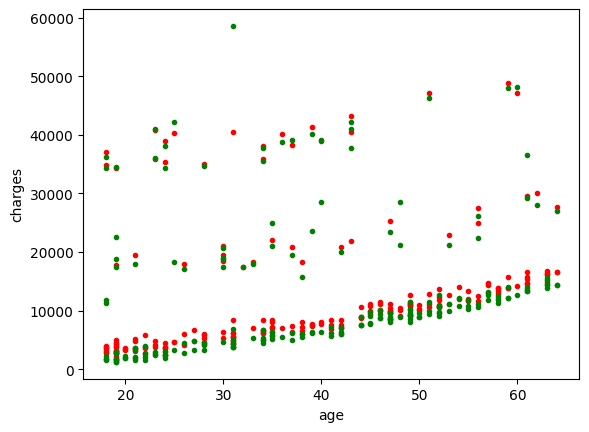

In [10]:
import matplotlib.pyplot as plt

#Charges = f ( age )
plt.xlabel("age")
plt.ylabel("charges")
plt.plot(X_test["age"], y_predicted, "r.")
plt.plot(X_test["age"], y_test, "g.")
plt.show()